In [46]:
import os
import os.path
import urllib.request
from scipy.integrate import odeint
import torch
from torch import nn, optim
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


In [2]:
# Fixed random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [3]:
# Download dataset from GitHub which was provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).
if not os.path.isfile("./dataset/time_series_19-covid-Confirmed.csv"):
    
    DATASET_NAME = {"time_series_19-covid-Confirmed.csv", "time_series_19-covid-Deaths.csv", "time_series_19-covid-Recovered.csv"}
    for name in DATASET_NAME:
        url = os.path.join("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series", name)
        r = urllib.request.urlretrieve(url, os.path.join("./dataset", name))


In [4]:
# Set train and test in Mathematical, Statistical and Machine learning model
temp_time_series_csv = pd.read_csv(os.path.join("dataset","time_series_19-covid-Confirmed.csv")).iloc[:, 4:].sum(axis=0)
TOTAL_DAYS = int(temp_time_series_csv.shape[0])
print(u"The number of days in the time-series data is {}.".format(TOTAL_DAYS))
## set test size is 14 days
TEST_SIZE = 14
TRAIN_SIZE = int(TOTAL_DAYS - TEST_SIZE)
print(u"We separate time-series data into 2 sets; Train and Test which their size are {} and {} respectively.".format(TRAIN_SIZE, TEST_SIZE))


The number of days in the time-series data is 43.
We separate time-series data into 2 sets; Train and Test which their size are 29 and 14 respectively.


In [5]:
# Set constant values
def set_seir(reproductive_number = 2):
    ## Total of population the world; scr: https://www.worldometers.info/world-population/
    population = 7768726098
    rate_of_brith = 1.05
    print(u"population of the world is {}.".format(population))

    ## recovery rate is the mean of recovered and death cases of the total cases
    _death = pd.read_csv(os.path.join("dataset","time_series_19-covid-Deaths.csv")).iloc[:, 4:].sum(axis=0)
    _death = _death.diff().fillna(_death[0]).astype(np.int64)
    _recovery = pd.read_csv(os.path.join("dataset","time_series_19-covid-Recovered.csv")).iloc[:, 4:].sum(axis=0)
    _recovery = _recovery.diff().fillna(_recovery[0]).astype(np.int64)
    _recovery_and_death = _death + _recovery
    _recovery_and_death = _recovery_and_death.pct_change().fillna("0").astype(np.int64)
    rate_of_recover_and_death = _recovery_and_death.mean()
    print(u"recovery rate is {}.".format(rate_of_recover_and_death))

    ## incubation rate is the mean of confirmed cases of the total cases
    _confirmed = pd.read_csv(os.path.join("dataset","time_series_19-covid-Confirmed.csv")).iloc[:, 4:].sum(axis=0)
    _confirmed = _confirmed.diff().fillna(_confirmed[0]).astype(np.int64)
    _confirmed = _confirmed.pct_change().fillna("0").astype(np.int64)
    rate_of_incubation = _confirmed.mean()
    print(u"incubation rate is {}.".format(rate_of_incubation))

    ## contact rate will calculated by assume that R_0 = 2 then contact rate = R_0 * reconvery rate
    rate_of_contactive =  reproductive_number * rate_of_recover_and_death
    print(u"contact rate is {}.".format(rate_of_contactive))
    return population, rate_of_contactive, rate_of_incubation, rate_of_recover_and_death

def seir_model(day_zero = -1):
    ''' SEIR model without vital dynamics '''
    # I've adapted code from original sorces https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
    # and https://institutefordiseasemodeling.github.io/Documentation/general/model-seir.html#id11

    # Total population, N; 
    N = population
    # Initial number of infected, exposed and recovered individuals, I0, E0 and R0.
    ## Initial rnumber of recovered cases is the number of recovered plus death cases in the lastest day in the time series 
    ### day_zero = -1 means use the lastest day in the time-series as day 0 of epidemic
    R0 = pd.read_csv(os.path.join("dataset","time_series_19-covid-Deaths.csv")).iloc[:, day_zero].sum(axis=0).astype(np.int64) +\
            pd.read_csv(os.path.join("dataset","time_series_19-covid-Recovered.csv")).iloc[:, day_zero].sum(axis=0).astype(np.int64)
    ## Initial rnumber of infected cases is confirmed minus death and recovered cases in lastest day in the time series 
    I0 = pd.read_csv(os.path.join("dataset","time_series_19-covid-Confirmed.csv")).iloc[:, day_zero].sum(axis=0).astype(np.int64) - R0
    ## assume that confirmed cases is nothing but merely the tip of the iceberg; therefore, let confirmed infected group is ten percent of exposed group.
    E0 = 10 * I0 
    S0 = N - I0 - R0 - E0
    print(u"Initial number of infected, exposed and recovered individuals are {}, {}, and {} respectively.".format(I0, E0, R0))
    print(u"Now, the initial number of susceptible individuals is {}.".format(S0))

    # Average contact rate(beta), incubation rate(alpha) and recovery rate(gamma) (in 1/days); 
    beta = rate_of_contactive
    alpha = rate_of_incubation
    gamma = rate_of_recover_and_death

    # A grid of time points (in days)
    DAYS_TO_PREDICT = 42 + 28 ## use the answer to life the universe and everything + 28 days later
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)

    # The SIR model differential equations.
    def deriv(y, t, N, alpha, beta, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S *  I / N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, alpha, beta, gamma))
    S, E, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, E/1000000, 'y', alpha=0.5, lw=2, label='Exposed')
    plt.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, R/1000000, 'g', alpha=0.5, lw=2, label='Recovered with immunity or Death')
    plt.xlabel('days from now')
    plt.ylabel('Number (millionth)')
    plt.grid(b=True, which='major', c='w', lw=2, ls='-')
    plt.legend()
    plt.title("SEIR model")
    plt.savefig("seir_model.jpg")
    plt.show()
    plt.close()

    ## from now on model
    if day_zero != -TEST_SIZE:
        plt.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Predicted Infected cases')
        plt.xlabel('days from now')
        plt.ylabel('Number (millionth)')
        plt.legend()
        plt.title("SEIR model for prediction infected cases (future)")
        plt.savefig("future_seir_model.jpg")
        plt.show()
        plt.close()

    else:
        total_confirmed = cases(csv="time_series_19-covid-Confirmed.csv", name="confirmed")[-TEST_SIZE:]
        total_death = cases(csv="time_series_19-covid-Deaths.csv", name="deaths")[-TEST_SIZE:]
        total_recovered = cases(csv="time_series_19-covid-Recovered.csv", name="recovered")[-TEST_SIZE:]
        real_I = total_confirmed - total_death - total_recovered
        plt.plot(real_I.index[:TEST_SIZE], real_I/1000000, 'r', alpha=0.5, lw=2, label='Real Infected cases')
        plt.plot(real_I.index[:TEST_SIZE], I[:TEST_SIZE]/1000000, 'b', alpha=0.5, lw=2, label='Predicted Infected cases')
        plt.xlabel(u'{} days ago to now'.format(TEST_SIZE))
        plt.ylabel('Number (millionth)')
        plt.title("SEIR model for prediction infected cases (validation)")
        plt.xticks(rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.savefig("validation_seir_model.jpg")
        plt.show()
        plt.close()


In [6]:
def cases(csv, name):
    # load dataset
    df = pd.read_csv(os.path.join("dataset",csv))
    #print(df.head())

    # select only time series parts
    df = df.iloc[:, 4:]

    # check missing values
    if df.isnull().sum().sum():
        print("There are missing values, do some thing with them.")

    # get number of cases of the day
    cases = df.sum(axis=0)
    
    # show graph of confirmed cases
    plt.plot(cases)
    plt.title(name+" cases")
    plt.xticks(rotation=45)
    plt.savefig(name+"_cases.jpg")
    #plt.show()
    plt.close()

    # get only number of new cases of the day
    daily_cases = cases.diff().fillna(cases[0]).astype(np.int64)

    # show graph of daily confirmed cases
    plt.plot(daily_cases)
    plt.title("daily "+name+" cases")
    plt.xticks(rotation=45)
    plt.savefig("daily_"+name+"_cases.jpg")
    #plt.show()
    plt.close()

    # show graph of daily and total of the day
    plt.plot(cases, label="Total cases")
    plt.plot(daily_cases, label="Daily cases")
    plt.title("Daily and total "+name+" cases")
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig("daily_total_"+name+"_cases.jpg")
    #plt.show()
    plt.close()
    
    return cases

def build_lstm(time_series_data, name):
    print("+"*50)
    print(u"Building LSTM model for {} group.".format(name))
    ''' Long-short Term Memory network '''
    ## I've adapted code from original source: https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0#scrollTo=iPJMdlBEErg3
    train = time_series_data[:-TEST_SIZE]
    test = time_series_data[-TEST_SIZE:]

    # preprocessing data
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(train, axis=1))
    train = scaler.transform(np.expand_dims(train, axis=1))
    test = scaler.transform(np.expand_dims(test, axis=1))

    def create_sequences(data, seq_length):
        xs = []
        ys = []

        for i in range(len(data)-seq_length-1):
            x = data[i:(i+seq_length)]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    # data preparing
    seq_length = 5
    X_train, y_train = create_sequences(train, seq_length)
    X_test, y_test = create_sequences(test, seq_length)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()

    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # model training
    ## define recurrent neural network architecture
    class CoronaVirusPredictor(nn.Module):

        def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
            super(CoronaVirusPredictor, self).__init__()

            self.n_hidden = n_hidden
            self.seq_len = seq_len
            self.n_layers = n_layers

            self.lstm = nn.LSTM(
                        input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        dropout=0.5
                        )

            self.linear = nn.Linear(in_features=n_hidden, out_features=1)

        def reset_hidden_state(self):
            self.hidden = (
                            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
                        )

        def forward(self, sequences):
            lstm_out, self.hidden = self.lstm(
                                    sequences.view(len(sequences), self.seq_len, -1),
                                    self.hidden
                                    )

            last_time_step = \
                lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]

            y_pred = self.linear(last_time_step)
            return y_pred

    
    ## define training method
    def train_model(model, train, train_labels, test_data=None, test_labels=None):
        loss_fn = torch.nn.MSELoss(reduction='sum')

        optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
        num_epochs = 120

        train_hist = np.zeros(num_epochs)
        test_hist = np.zeros(num_epochs)

        for t in range(num_epochs):
            model.reset_hidden_state()

            y_pred = model(X_train)

            loss = loss_fn(y_pred.float(), y_train)

            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(X_test)
                    test_loss = loss_fn(y_test_pred.float(), y_test)

                test_hist[t] = test_loss.item()

                if t % 10 == 0:  
                    print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

            elif t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()}')

            train_hist[t] = loss.item()
            
            optimiser.zero_grad()

            loss.backward()

            optimiser.step()
        
        return model.eval(), train_hist, test_hist

    ## building step here
    model = CoronaVirusPredictor(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
    model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)


    # prediction step
    def predict(data_seq, predict_len):
        seq = data_seq
        preds = []
        for _ in range(predict_len):
            y_pred = model(seq)
            pred = torch.flatten(y_pred).item()
            preds.append(pred)
            new_seq = seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

        predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
        return predicted_cases


    #self_predicted_cases = predict(X_train[:1], TRAIN_SIZE)
    validation_predicted_cases = predict(X_test[:1], TEST_SIZE)
    #validation_predicted_cases = np.append(self_predicted_cases, validation_predicted_cases)
    plt.plot(time_series_data[-TEST_SIZE:]/1000000, label="Real cases")
    plt.plot(validation_predicted_cases/1000000, label="Predicted cases")
    plt.ylabel('Number (millionth)')
    plt.xlabel("14 days ago to now")
    plt.title("LSTM model for "+name+" cases")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(name+"_lstm_model_validation.jpg")
    plt.show()
    plt.close()
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(time_series_data, axis=1))
    all_data = scaler.transform(np.expand_dims(time_series_data, axis=1))
    
    X_all, y_all = create_sequences(all_data, seq_length)
    X_all = torch.from_numpy(X_all).float()
    y_all = torch.from_numpy(y_all).float()
    
    model = CoronaVirusPredictor(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
    model, train_hist, _ = train_model(model, X_all, y_all)

    DAYS_TO_PREDICT = 42 + 28
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)
    predicted_cases = predict(X_test[-1:], DAYS_TO_PREDICT)
    plt.plot(t, predicted_cases/1000000, label='Predicted Cases')
    plt.xlabel("days from now")
    plt.ylabel('Number (millionth)')
    plt.title("LSTM model for "+name+" cases")
    plt.legend()
    plt.savefig(name+"_lstm_model.jpg")
    plt.show()
    plt.close()

    return validation_predicted_cases, predicted_cases

def lstm(time_series_data=[], validation_predicted_cases=[], predicted_cases=[]):
    time_series = time_series_data[0] - time_series_data[1] - time_series_data[2]
    validation_cases = validation_predicted_cases[0] - validation_predicted_cases[1] - validation_predicted_cases[2]
    future_cases = predicted_cases[0] - predicted_cases[1] - predicted_cases[2]
    # plot validation graph
    plt.plot(time_series[-TEST_SIZE:]/1000000, label="Real cases")
    plt.plot(validation_cases/1000000, label="Predicted cases")
    plt.ylabel('Number (millionth)')
    plt.xlabel("14 days ago to now")
    plt.title("LSTM model for prediction infected cases (validation)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig("validation_lstm_model.jpg")
    plt.show()
    plt.close()

    # plot prediction graph
    DAYS_TO_PREDICT = 42 + 28
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)
    plt.plot(t, future_cases/1000000, label='Predicted Cases')
    plt.xlabel("days from now")
    plt.ylabel('Number (millionth)')
    plt.title("LSTM model for prediction infected cases (future)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("future_lstm_model.jpg")
    plt.show()
    plt.close()


In [75]:
def is_stationary(total_cases):
    ''' ARIMA model '''
    # I've adapted code from original source: https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3,
    # https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
    # https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
    # https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
    # and https://www.statsmodels.org/stable/tsa.html

    SIGNIFICANCE = 0.05

    rolling_mean = total_cases.rolling(window = 7).mean()
    rolling_std = total_cases.rolling(window = 7).std()
    plt.plot(total_cases, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    result = adfuller(total_cases)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

    # let's calculate p-value to check if the timeseries is stationary
    if result[1] >= SIGNIFICANCE:
        print("This time-series is not stationary, d>0")
    else:
        print("This time-series is stationary, d=0")
        
def find_order(total_cases, partial=True):
    if not partial:
        fig = plt.figure(figsize=(10, 10))

        ax1 = fig.add_subplot(311)
        fig = plot_acf(total_cases, ax=ax1,
                       title="Prtial Autocorrelation on Original Series") 
        ax2 = fig.add_subplot(312)
        fig = plot_acf(total_cases.diff().dropna(), ax=ax2, 
                       title="1st Order Differencing")

        ax3 = fig.add_subplot(313)
        fig = plot_acf(total_cases.diff().diff().dropna(), ax=ax3, 
                       title="2nd Order Differencing")

    else:
        fig = plt.figure(figsize=(10, 10))

        ax1 = fig.add_subplot(311)
        fig = plot_pacf(total_cases, ax=ax1,
                       title="Prtial Autocorrelation on Original Series") 
        ax2 = fig.add_subplot(312)
        fig = plot_pacf(total_cases.diff().dropna(), ax=ax2, 
                       title="1st Order Differencing")

        ax3 = fig.add_subplot(313)
        fig = plot_pacf(total_cases.diff().diff().dropna(), ax=ax3, 
                       title="2nd Order Differencing")
        
def acf(total_cases):
    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(321)
    fig = plot_acf(total_cases, ax=ax1,
                   title="Autocorrelation on Original Series") 
    ax2 = fig.add_subplot(322)
    ax2.plot(total_cases)
    ax2.set_title("Autocorrelation on Original Series")
    plt.xticks(rotation=90)

    ax3 = fig.add_subplot(323)
    fig = plot_acf(total_cases.diff().dropna(), ax=ax3, 
                   title="1st Order Differencing")
    ax4 = fig.add_subplot(324)
    ax4.plot(total_cases.diff().dropna())
    ax4.set_title("1st Order Differencing")
    plt.xticks(rotation=90)

    ax5 = fig.add_subplot(325)
    fig = plot_acf(total_cases.diff().diff().dropna(), ax=ax5, 
                   title="2nd Order Differencing")
    ax6 = fig.add_subplot(326)
    ax6.plot(total_cases.diff().diff().dropna())
    ax6.set_title("2nd Order Differencing")
    plt.xticks(rotation=90)
    
def pacf(total_cases):
    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(321)
    fig = plot_pacf(total_cases, ax=ax1,
                   title="Partial Autocorrelation on Original Series") 
    ax2 = fig.add_subplot(322)
    ax2.plot(total_cases)
    ax2.set_title("Partial Autocorrelation on Original Series")
    plt.xticks(rotation=90)

    ax3 = fig.add_subplot(323)
    fig = plot_pacf(total_cases.diff().dropna(), ax=ax3, 
                   title="1st Order Differencing")
    ax4 = fig.add_subplot(324)
    ax4.plot(total_cases.diff().dropna())
    ax4.set_title("1st Order Differencing")
    plt.xticks(rotation=90)

    ax5 = fig.add_subplot(325)
    fig = plot_pacf(total_cases.diff().diff().dropna(), ax=ax5, 
                   title="2nd Order Differencing")
    ax6 = fig.add_subplot(326)
    ax6.plot(total_cases.diff().diff().dropna())
    ax6.set_title("2nd Order Differencing")
    plt.xticks(rotation=90)
    

def pdq_analysis(total_cases):
    # Find the order of differencing, d:
    print("WARNING!:  if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.")
    print("Finding the order of differencing (d) in ARIMA model")
    acf(total_cases)
    
    # Find the order of the MA, q:
    print("Finding the order of the MA term (q)")
    #acf(total_cases)
        
    # Find the order of AR; p
    print("Finding the order of the AR term (p)")
    pacf(total_cases)
    
    
def build_arima(total_cases, name, order): 
    # future
    DAYS_TO_PREDICT = 42+28
    model = ARIMA(total_cases, order=order)
    results = model.fit(disp=0)
    print(results.summary())
    
    residuals = pd.DataFrame(results.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    plt.close()
    
    figure = results.plot_predict(1, TOTAL_DAYS+DAYS_TO_PREDICT, dynamic=False)
    plt.title("ARIMA model for predition infected cases (future)")
    plt.savefig(name+"_arima_model.jpg")
    plt.show()
    plt.close()
    
    fc, _, _ = results.forecast(DAYS_TO_PREDICT, alpha=0.05)
    return fc
    
def build_arima_valiadation(total_cases, name, order):
    # validation
    model = ARIMA(total_cases[:-TEST_SIZE], order=order)
    results = model.fit(disp=0)
    print(results.summary())
    fc, se, conf = results.forecast(TEST_SIZE, alpha=0.05)  # 95% conf
    fc_series = pd.Series(fc, index=total_cases[-TEST_SIZE:].index)
    lower_series = pd.Series(conf[:, 0], index=total_cases[-TEST_SIZE:].index)
    upper_series = pd.Series(conf[:, 1], index=total_cases[-TEST_SIZE:].index)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(total_cases[:-TEST_SIZE], label='training')
    plt.plot(total_cases[-TEST_SIZE:], label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('ARIMA model for predition infected cases (validation)')
    plt.legend(loc='upper left', fontsize=8)
    plt.savefig(name+"_varidation_arima_model.jpg")
    plt.show()
    plt.close()
    return fc
    
def arima(time_series_data=[], validation_predicted_cases=[], predicted_cases=[]):
    time_series = time_series_data[0] - time_series_data[1] - time_series_data[2]
    validation_cases = validation_predicted_cases[0] - validation_predicted_cases[1] - validation_predicted_cases[2]
    future_cases = predicted_cases[0] - predicted_cases[1] - predicted_cases[2]
    # plot validation graph
    plt.plot(time_series[-TEST_SIZE:]/1000000, label="Real cases")
    plt.plot(validation_cases/1000000, label="Predicted cases")
    plt.ylabel('Number (millionth)')
    plt.xlabel("14 days ago to now")
    plt.title("ARIMA model for prediction infected cases (validation)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig("validation_arima_model.jpg")
    plt.show()
    plt.close()

    # plot prediction graph
    DAYS_TO_PREDICT = 42 + 28
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)
    plt.plot(t, future_cases/1000000, label='Predicted Cases')
    plt.xlabel("days from now")
    plt.ylabel('Number (millionth)')
    plt.title("ARIMA model for prediction infected cases (future)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("future_arima_model.jpg")
    plt.show()
    plt.close()

####################################################################################################
population of the world is 7768726098.
recovery rate is 0.32558139534883723.
incubation rate is 0.9767441860465116.
contact rate is 0.6511627906976745.
Initial number of infected, exposed and recovered individuals are 55775, 557750, and 20424 respectively.
Now, the initial number of susceptible individuals is 7768092149.


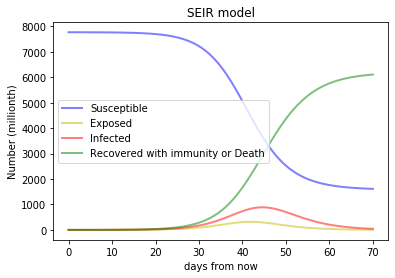

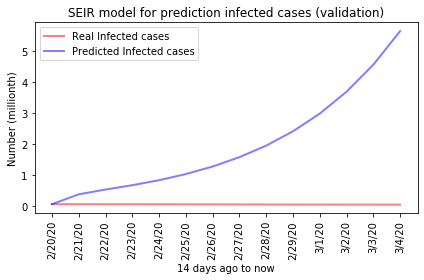

In [7]:
print("#"*100)
# mathematical model; SEIR model, a compartmental models in epidemiology.
population, rate_of_contactive, rate_of_incubation, rate_of_recover_and_death = set_seir(reproductive_number = 2)
seir_model(day_zero = -TEST_SIZE ) ## model from 14 days ago

Initial number of infected, exposed and recovered individuals are 40699, 406990, and 54425 respectively.
Now, the initial number of susceptible individuals is 7768223984.


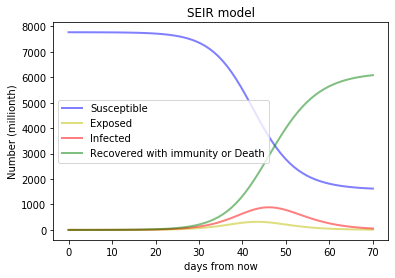

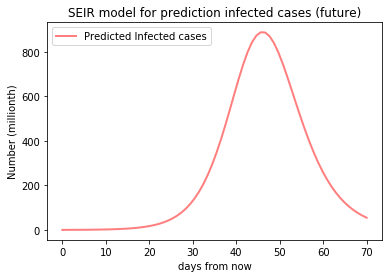

In [8]:
seir_model() ## model from now on

In [9]:
print("#"*100)
# machine learning model; Long-short Term Memory network (as known as LSTM model), a type of recurrent neural network designed model.
total_confirmed = cases(csv="time_series_19-covid-Confirmed.csv", name="confirmed")
total_death = cases(csv="time_series_19-covid-Deaths.csv", name="deaths")
total_recovered = cases(csv="time_series_19-covid-Recovered.csv", name="recovered")


####################################################################################################


++++++++++++++++++++++++++++++++++++++++++++++++++
Building LSTM model for confirmed group.
Epoch 0 train loss: 7.01185941696167 test loss: 10.107826232910156
Epoch 10 train loss: 4.306817054748535 test loss: 7.256630897521973
Epoch 20 train loss: 2.148855209350586 test loss: 3.114924192428589
Epoch 30 train loss: 2.1392836570739746 test loss: 2.7109181880950928
Epoch 40 train loss: 2.1978769302368164 test loss: 3.4513401985168457
Epoch 50 train loss: 2.1667723655700684 test loss: 2.4329731464385986
Epoch 60 train loss: 2.085071325302124 test loss: 2.4554474353790283
Epoch 70 train loss: 2.0292396545410156 test loss: 2.2909579277038574
Epoch 80 train loss: 1.955574631690979 test loss: 1.7114598751068115
Epoch 90 train loss: 1.8702642917633057 test loss: 1.0032415390014648
Epoch 100 train loss: 1.6491830348968506 test loss: 0.07393348962068558
Epoch 110 train loss: 1.350415587425232 test loss: 31.530168533325195


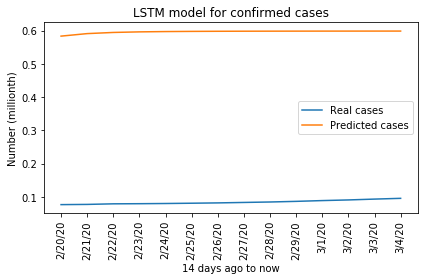

Epoch 0 train loss: 6.57260274887085
Epoch 10 train loss: 3.891502618789673
Epoch 20 train loss: 2.2259867191314697
Epoch 30 train loss: 2.176145315170288
Epoch 40 train loss: 2.1675469875335693
Epoch 50 train loss: 2.1043059825897217
Epoch 60 train loss: 2.0718955993652344
Epoch 70 train loss: 2.0031023025512695
Epoch 80 train loss: 1.8565571308135986
Epoch 90 train loss: 1.6909816265106201
Epoch 100 train loss: 1.3921126127243042
Epoch 110 train loss: 1.3251979351043701


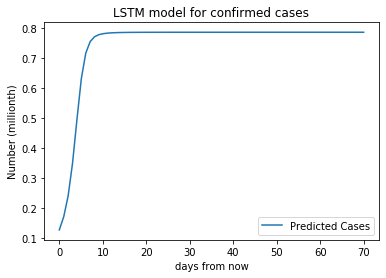

In [10]:
confirmed_validation_predicted_cases, confirmed_predicted_cases = build_lstm(total_confirmed, name="confirmed")

++++++++++++++++++++++++++++++++++++++++++++++++++
Building LSTM model for deaths group.
Epoch 0 train loss: 6.229803085327148 test loss: 16.163679122924805
Epoch 10 train loss: 3.6319284439086914 test loss: 12.459075927734375
Epoch 20 train loss: 1.8322069644927979 test loss: 6.302316665649414
Epoch 30 train loss: 1.7921507358551025 test loss: 6.638753414154053
Epoch 40 train loss: 1.8484811782836914 test loss: 7.293510437011719
Epoch 50 train loss: 1.7591612339019775 test loss: 5.817065238952637
Epoch 60 train loss: 1.7390825748443604 test loss: 5.988015174865723
Epoch 70 train loss: 1.748038649559021 test loss: 5.6243486404418945
Epoch 80 train loss: 1.679072618484497 test loss: 4.665187835693359
Epoch 90 train loss: 1.5800856351852417 test loss: 3.8426241874694824
Epoch 100 train loss: 1.515110731124878 test loss: 2.032447338104248
Epoch 110 train loss: 1.2706722021102905 test loss: 0.2962714731693268


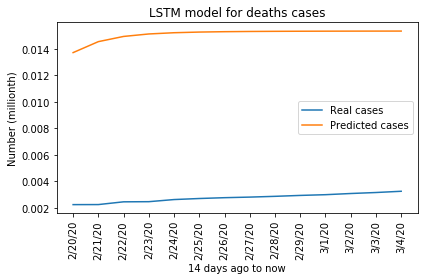

Epoch 0 train loss: 4.995563983917236
Epoch 10 train loss: 2.895702362060547
Epoch 20 train loss: 1.8802127838134766
Epoch 30 train loss: 1.826714277267456
Epoch 40 train loss: 1.833694338798523
Epoch 50 train loss: 1.7546970844268799
Epoch 60 train loss: 1.7490047216415405
Epoch 70 train loss: 1.7358535528182983
Epoch 80 train loss: 1.6706581115722656
Epoch 90 train loss: 1.587438702583313
Epoch 100 train loss: 1.428235411643982
Epoch 110 train loss: 1.065209150314331


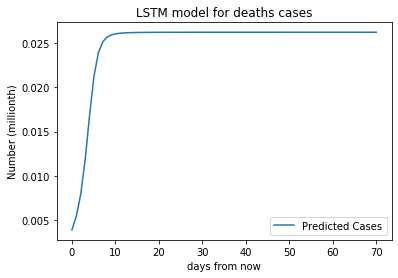

In [11]:
deaths_validation_predicted_cases, deaths_predicted_cases = build_lstm(total_death, name="deaths")


++++++++++++++++++++++++++++++++++++++++++++++++++
Building LSTM model for recovered group.
Epoch 0 train loss: 3.185826301574707 test loss: 47.2400016784668
Epoch 10 train loss: 1.9288337230682373 test loss: 41.073936462402344
Epoch 20 train loss: 1.6607632637023926 test loss: 33.79991912841797
Epoch 30 train loss: 1.6100276708602905 test loss: 34.887020111083984
Epoch 40 train loss: 1.5853428840637207 test loss: 34.339637756347656
Epoch 50 train loss: 1.5585190057754517 test loss: 31.5040283203125
Epoch 60 train loss: 1.498006820678711 test loss: 28.94172477722168
Epoch 70 train loss: 1.4451391696929932 test loss: 25.477495193481445
Epoch 80 train loss: 1.3598506450653076 test loss: 17.472179412841797
Epoch 90 train loss: 1.2001432180404663 test loss: 3.0414581298828125
Epoch 100 train loss: 0.925305962562561 test loss: 73.5456771850586
Epoch 110 train loss: 0.8708019256591797 test loss: 180.7271728515625


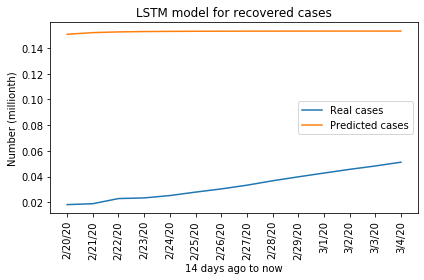

Epoch 0 train loss: 2.754582643508911
Epoch 10 train loss: 1.7556185722351074
Epoch 20 train loss: 1.691535472869873
Epoch 30 train loss: 1.563745141029358
Epoch 40 train loss: 1.5660583972930908
Epoch 50 train loss: 1.5219295024871826
Epoch 60 train loss: 1.4836894273757935
Epoch 70 train loss: 1.4171037673950195
Epoch 80 train loss: 1.3084235191345215
Epoch 90 train loss: 0.9660835266113281
Epoch 100 train loss: 0.8036375641822815
Epoch 110 train loss: 0.7197234630584717


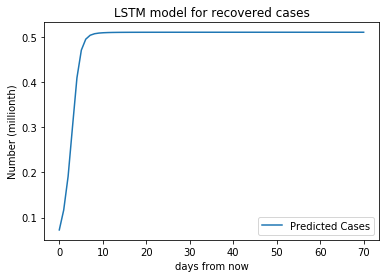

In [12]:
recovered_validation_predicted_cases, recovered_predicted_cases = build_lstm(total_recovered, name="recovered")


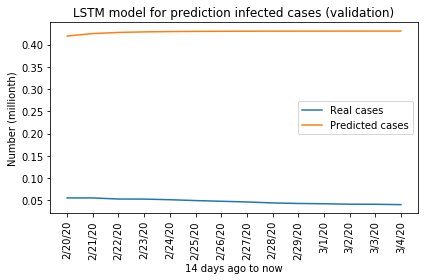

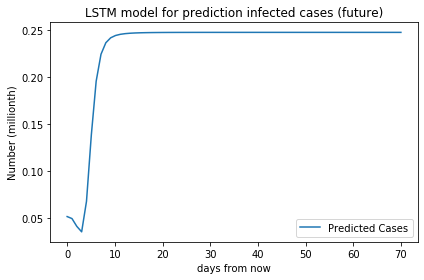

In [13]:
lstm(time_series_data=[total_confirmed, total_death, total_recovered],
     validation_predicted_cases=[confirmed_validation_predicted_cases, deaths_validation_predicted_cases, recovered_validation_predicted_cases],
     predicted_cases=[confirmed_predicted_cases, deaths_predicted_cases, recovered_predicted_cases])


In [76]:
print("#"*100)
# statistical model; ARIMA model, a time-series model.
total_confirmed = cases(csv="time_series_19-covid-Confirmed.csv", name="confirmed")
total_death = cases(csv="time_series_19-covid-Deaths.csv", name="deaths")
total_recovered = cases(csv="time_series_19-covid-Recovered.csv", name="recovered")

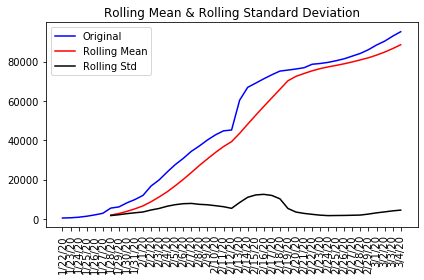

ADF Statistic: -0.3228577180685934
p-value: 0.9222040272846319
Critical Values:
	1%: -3.596635636000432
	5%: -2.933297331821618
	10%: -2.6049909750566895
This time-series is not stationary, d>0
WARNING!:  if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.
Finding the order of differencing (d) in ARIMA model
Finding the order of the MA term (q)
Finding the order of the AR term (p)


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -384.798
Method:                       css-mle   S.D. of innovations           2302.553
Date:                Fri, 06 Mar 2020   AIC                            777.595
Time:                        03:26:49   BIC                            784.546
Sample:                    01-23-2020   HQIC                           780.143
                         - 03-04-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2216.0683    546.650      4.054      0.000    1144.654    3287.483
ar.L1.D.y      0.5349      0.691      0.774      0.439      -0.819       1.889
ma.L1.D.y     -0.2777      0.807     -0.344      0.7

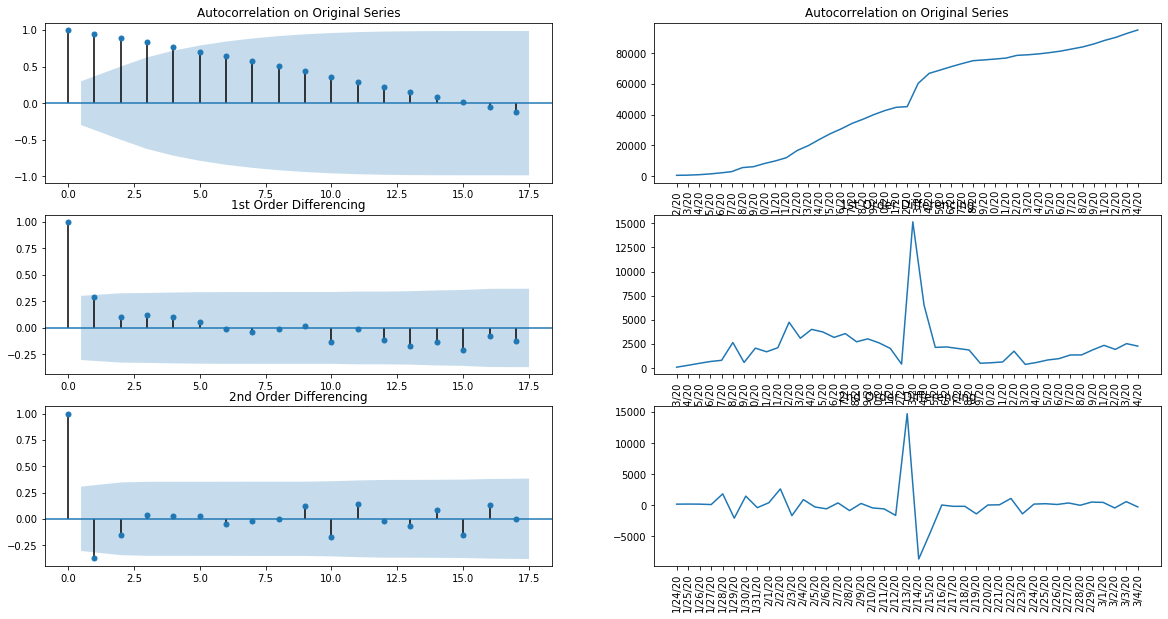

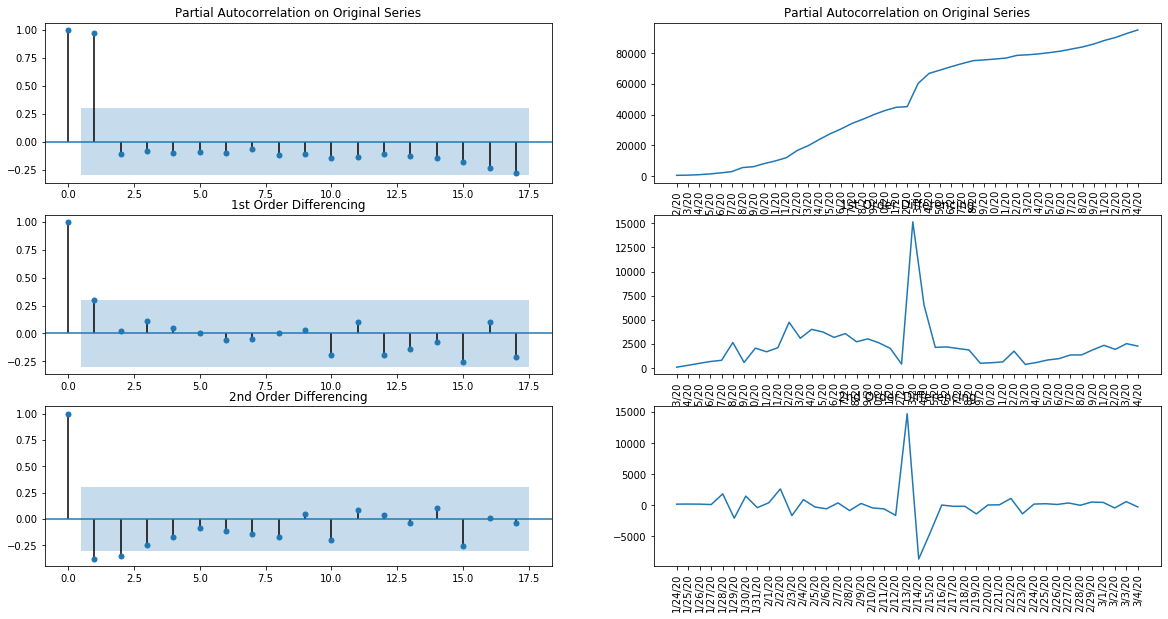

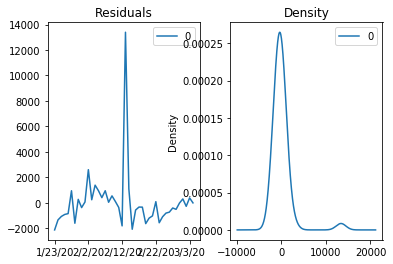

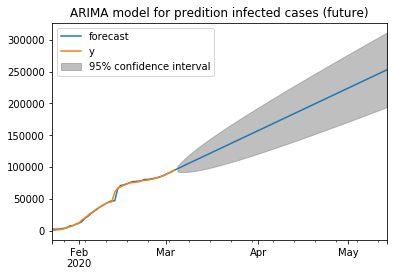

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -261.948
Method:                       css-mle   S.D. of innovations           2773.313
Date:                Fri, 06 Mar 2020   AIC                            531.897
Time:                        03:26:52   BIC                            537.225
Sample:                    01-23-2020   HQIC                           533.526
                         - 02-19-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2711.8830    416.430      6.512      0.000    1895.696    3528.070
ar.L1.D.y      0.9570      0.087     11.063      0.000       0.787       1.127
ma.L1.D.y     -1.0000      0.066    -15.053      0.0

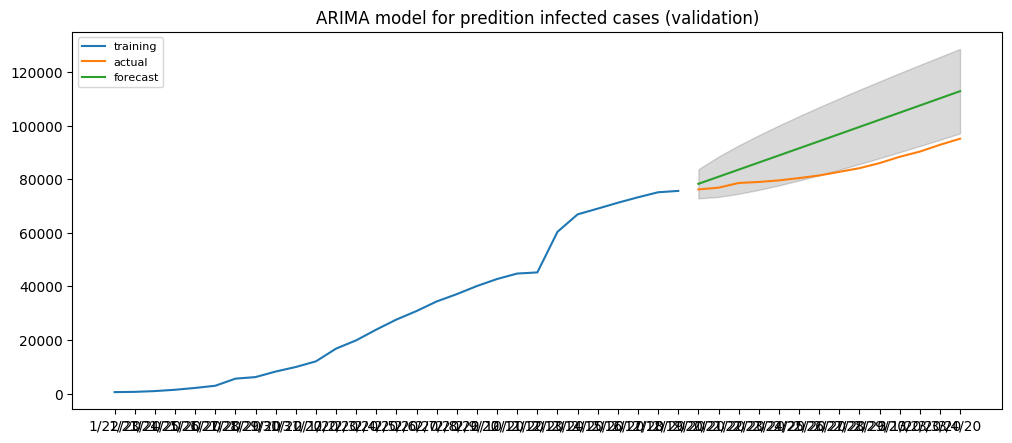

In [89]:
is_stationary(total_confirmed)
pdq_analysis(total_confirmed)
order = (1,1,1)
arima_confirmed = build_arima(total_cases=total_confirmed, name="confirmed", order=order)
arima_confirmed_validation = build_arima_valiadation(total_cases=total_confirmed, name="confirmed", order=order)

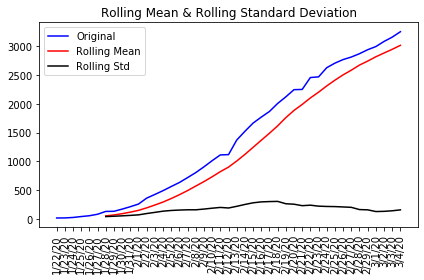

ADF Statistic: 0.39687459192888885
p-value: 0.9813776858048686
Critical Values:
	1%: -3.6055648906249997
	5%: -2.937069375
	10%: -2.606985625
This time-series is not stationary, d>0
WARNING!:  if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.
Finding the order of differencing (d) in ARIMA model
Finding the order of the MA term (q)
Finding the order of the AR term (p)


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -224.004
Method:                       css-mle   S.D. of innovations             49.869
Date:                Fri, 06 Mar 2020   AIC                            456.007
Time:                        03:09:42   BIC                            462.958
Sample:                    01-23-2020   HQIC                           458.555
                         - 03-04-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.0626     23.599      2.884      0.004      21.809     114.316
ar.L1.D.y      0.9254      0.078     11.914      0.000       0.773       1.078
ma.L1.D.y     -0.7390      0.107     -6.904      0.0

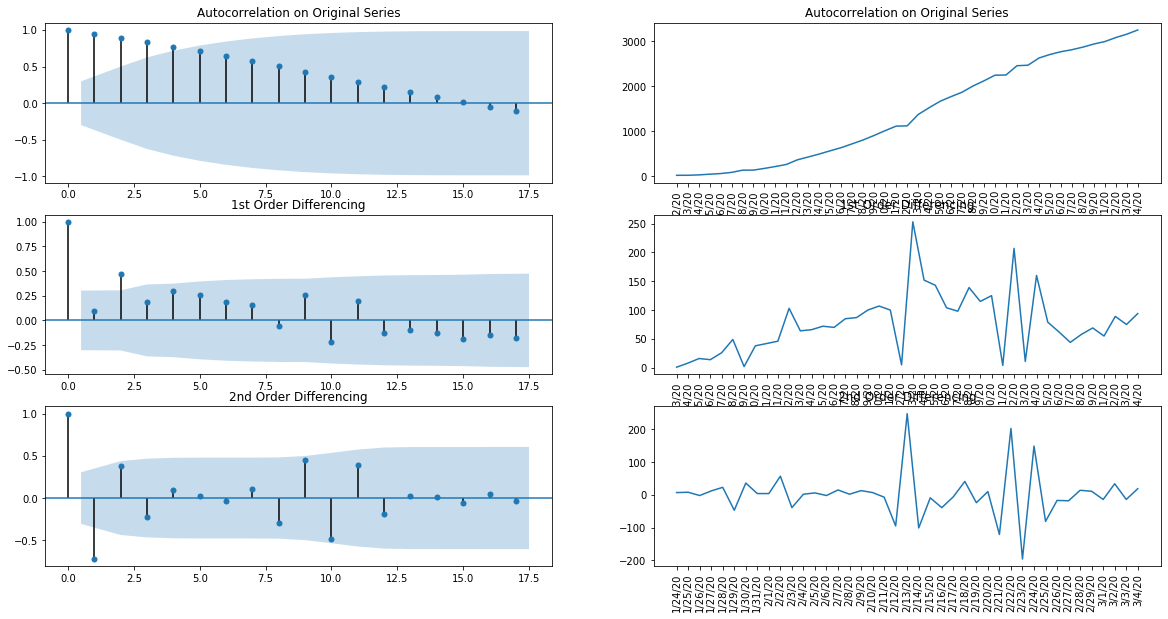

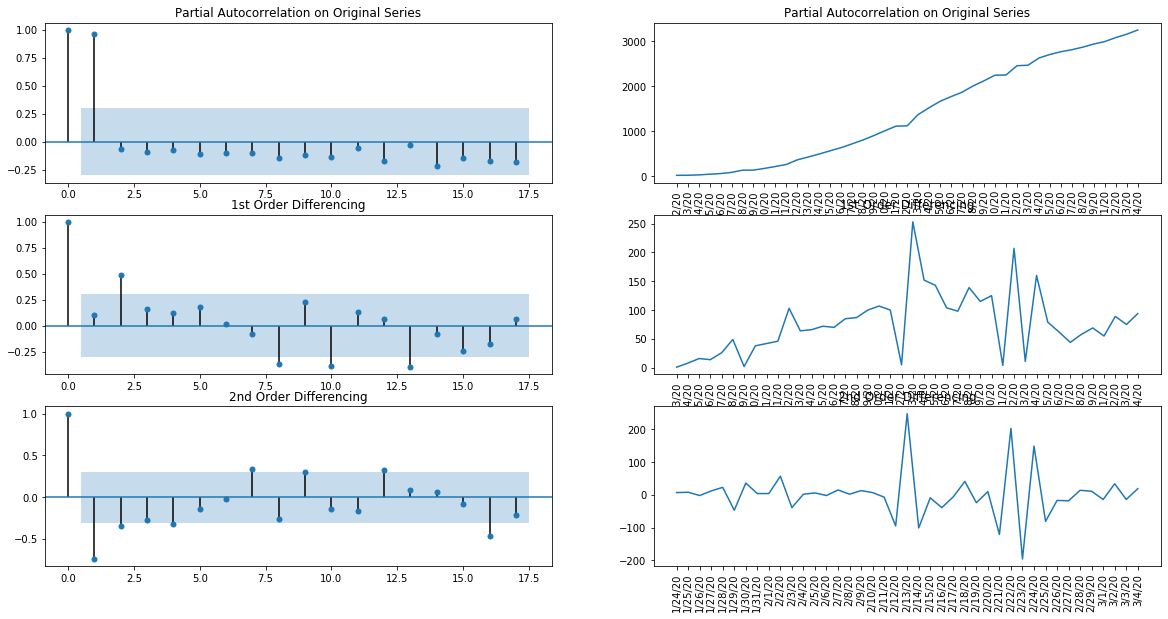

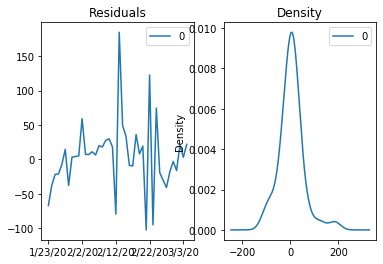

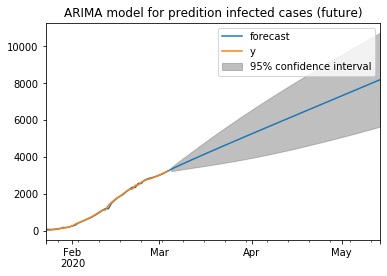

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.6/site-packages/scipy/stats/_dis

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -177.520
Method:                       css-mle   S.D. of innovations            137.147
Date:                Fri, 06 Mar 2020   AIC                            363.040
Time:                        03:09:46   BIC                            368.369
Sample:                    01-23-2020   HQIC                           364.669
                         - 02-19-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        200.5536        nan        nan        nan         nan         nan
ar.L1.D.y      1.0000      0.007    146.811      0.000       0.987       1.013
ma.L1.D.y     -1.0000   1.01e-05  -9.92e+04      0.0

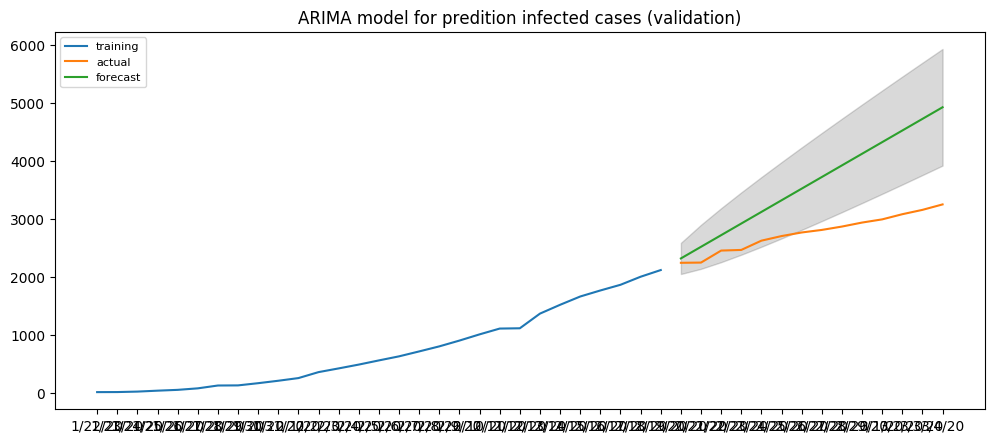

In [78]:
is_stationary(total_death)
pdq_analysis(total_death)
order = (1,1,1)
arima_death = build_arima(total_cases=total_death, name="deaths", order=order)
arima_death_validation = build_arima_valiadation(total_cases=total_death, name="deaths", order=order)

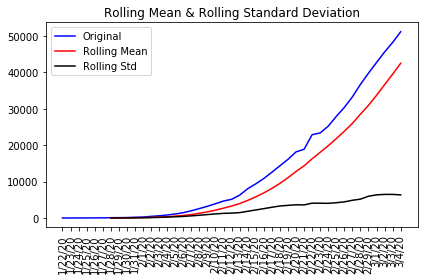

ADF Statistic: 0.35848578519033547
p-value: 0.9798742872920735
Critical Values:
	1%: -3.610399601308181
	5%: -2.939108945868946
	10%: -2.6080629651545038
This time-series is not stationary, d>0
WARNING!:  if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.
Finding the order of differencing (d) in ARIMA model
Finding the order of the MA term (q)
Finding the order of the AR term (p)


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -330.987
Method:                       css-mle   S.D. of innovations            624.870
Date:                Fri, 06 Mar 2020   AIC                            669.974
Time:                        03:09:48   BIC                            676.925
Sample:                    01-23-2020   HQIC                           672.522
                         - 03-04-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1379.5989   1137.347      1.213      0.225    -849.561    3608.758
ar.L1.D.y      0.9847      0.021     47.729      0.000       0.944       1.025
ma.L1.D.y     -0.6399      0.086     -7.403      0.0

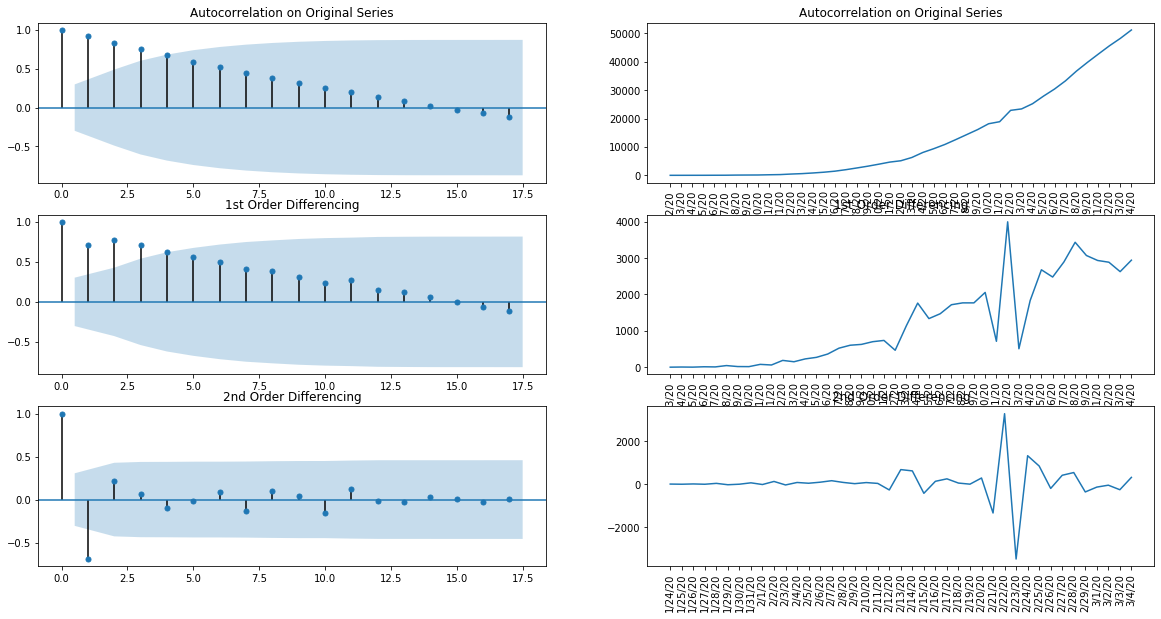

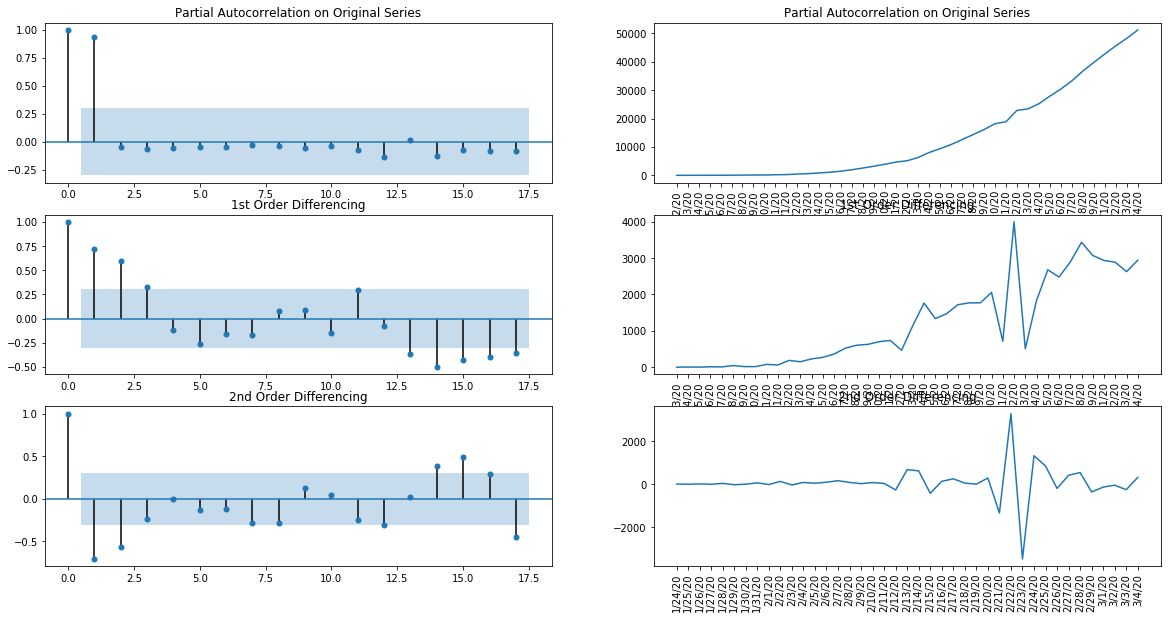

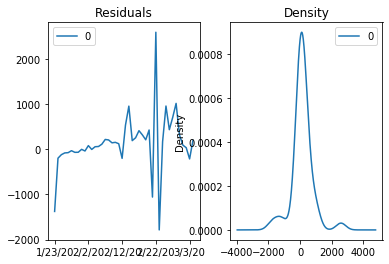

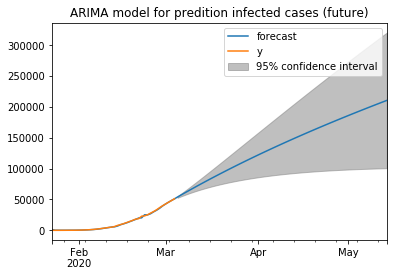

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -191.299
Method:                       css-mle   S.D. of innovations            214.351
Date:                Fri, 06 Mar 2020   AIC                            390.597
Time:                        03:09:52   BIC                            395.926
Sample:                    01-23-2020   HQIC                           392.226
                         - 02-19-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        765.6189    617.494      1.240      0.215    -444.647    1975.885
ar.L1.D.y      0.9570      0.061     15.814      0.000       0.838       1.076
ma.L1.D.y      0.0390      0.385      0.101      0.9

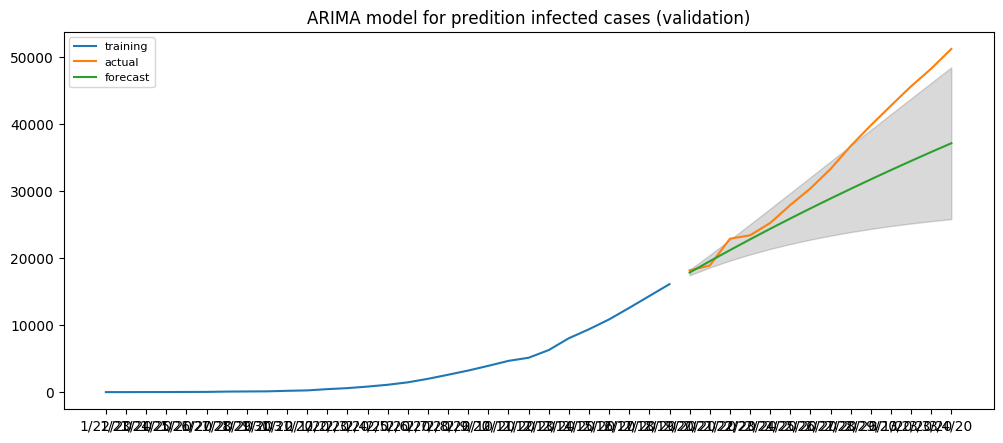

In [79]:
is_stationary(total_recovered)
pdq_analysis(total_recovered)
order = (1,1,1)
arima_recovered = build_arima(total_cases=total_recovered, name="recovered", order=order)
arima_recovered_validation = build_arima_valiadation(total_cases=total_recovered, name="recovered", order=order)

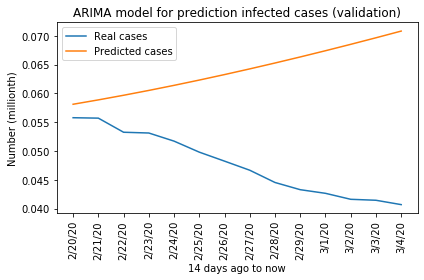

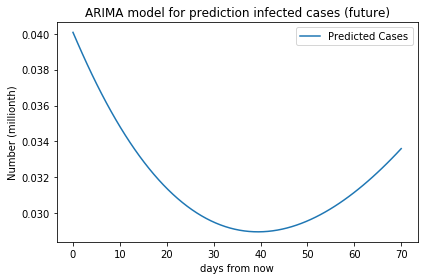

In [90]:
arima(time_series_data=[total_confirmed, total_death, total_recovered], 
      validation_predicted_cases=[arima_confirmed_validation, arima_death_validation, arima_recovered_validation], 
      predicted_cases=[arima_confirmed, arima_death, arima_recovered])